# Watson Conversation Analysis

Esse notebook te permite realizar algumas análises referentes ao corpus inserido no Bot utilizando o Watson Conversation.

In [38]:
# Importação das bibliotecas necessárias

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

import pandas as pd
import numpy as np
import requests
import json

## Credenciais do seu conversation
Para obter as credenciais do seu conversation acesse a aba "credentials" no painel esquerdo do seu Workspace.

**! Não é uma boa prática manter as suas credenciais fixadas no código a ser executado, normalmente você teria algo como um arquivo *credentials.json* e importaria essas informações aqui**

In [39]:
conv_user = '4612cebd-3c6f-47d7-b5e6-fd260be0f277'
conv_pass = '06RRVdJMNCbD'
workspaceId = 'f731a11d-42a9-4db6-8589-936040dceed0'

base_url = 'https://gateway.watsonplatform.net/conversation/api/v1/workspaces/' + workspaceId 
url_intents = base_url + '/intents?version=2017-04-21&export=true'
url_logs = base_url + '/logs?version=2017-04-21'

## Distribuição das intenções
Com o código abaixo você poderá obter todas as intenções presentes no seu bot e analisá-las de forma visual a distribuição das mesmas.

** É uma boa prática manter as suas classes com uma quantidade semelhante de exemplos e por isso estamos selecionando aquelas que possuem exemplos de mais ou de menos **

Média de exemplos por classe: 6.470588235294118


Classes com uma quantidade discrepante de exemplos (class@num_exemplos):

chamarDiscovery @ 17
dividas_rurais_docDividas @ 10
download @ 11


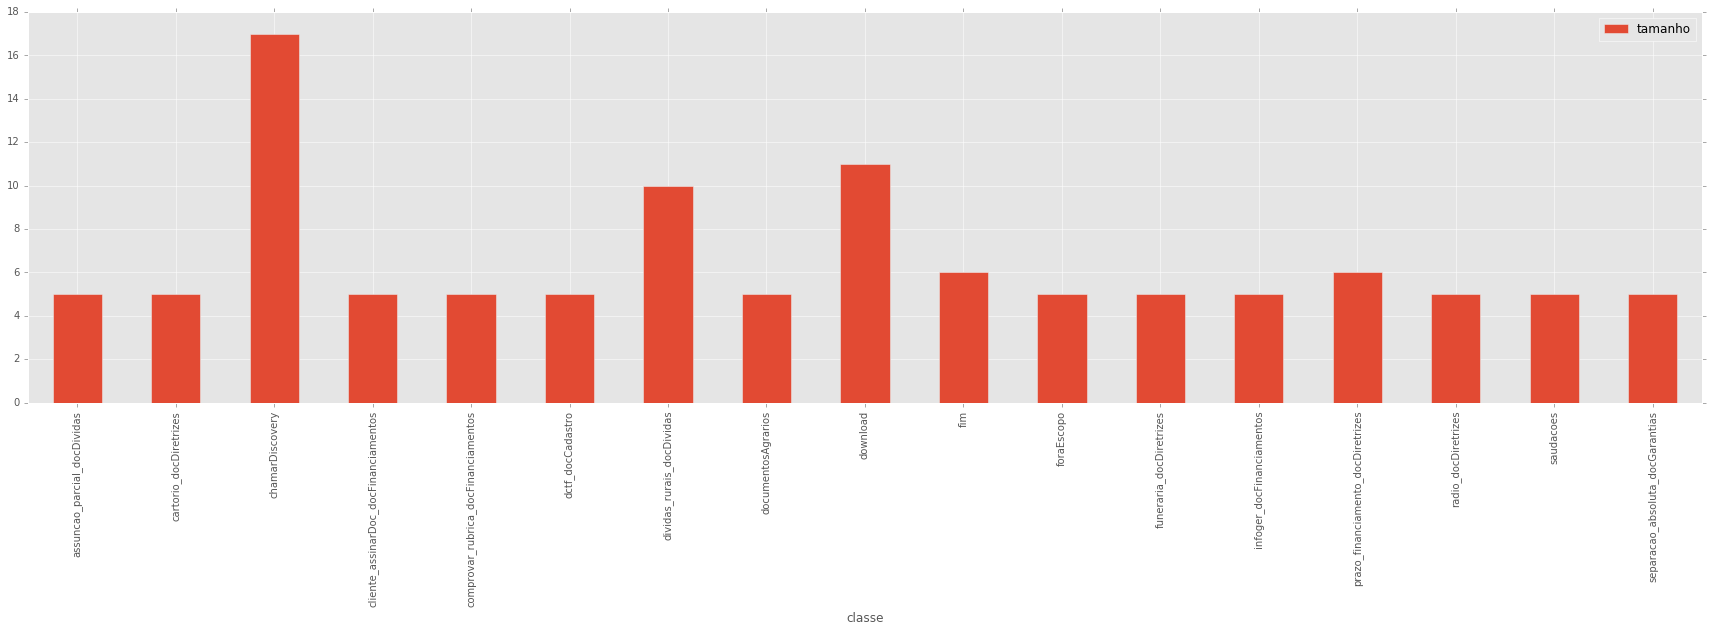

In [40]:
r = requests.get(url_intents, auth=(conv_user, conv_pass))
json_response_intents = r.json()

df = pd.DataFrame(columns=['classe', 'tamanho'])
avg_size = 0;

c = 0
for intent in json_response_intents['intents']:
    df.loc[c] = pd.Series({'classe':intent['intent'], 'tamanho': len(intent['examples'])})
    avg_size = avg_size + len(intent['examples'])
    c = c+1

plt.figure();
df.plot(kind='bar',x='classe', y='tamanho',figsize=(30,7))

avg_size = avg_size/len(json_response_intents['intents'])
print("Média de exemplos por classe: " + str(avg_size))

print("\n\nClasses com uma quantidade discrepante de exemplos (class@num_exemplos):\n")

for intent in json_response_intents['intents']:
    if(abs(len(intent['examples']) - avg_size) > (avg_size*0.5)):
        print(intent['intent'] + ' @ ' + str(len(intent['examples'])))

## Distribuição das conversas
Agora vamos analisar o que o nosso classificador está encontrando no dia-a-dia.

In [41]:
r = requests.get(url_logs, auth=(conv_user, conv_pass))
json_response_logs = r.json()

df2 = pd.DataFrame(columns=['classe', 'tamanho','somaconfianca'])

#print(json_response_logs['logs'])
c = 0
avg_conf = 0
for log in json_response_logs['logs']:
    if(log['response']['intents']):
        df2.loc[c] = pd.Series({'classe': log['response']['intents'][0]['intent'], 'tamanho': 1,'somaconfianca': log['response']['intents'][0]['confidence']})
        avg_conf = avg_conf + log['response']['intents'][0]['confidence']
        c = c+1

### Confiança Geral
Aqui podemos obter a confiança geral de todas as interações realizadas com os nossos usuários **no entanto precisamos pensar no que esse número reflete de verdade:**
A confiança geral das conversas não é um bom demonstrativo do nível de acurácia geral do nosso bot. Imagine os seguintes exemplos:

#### Exemplo 1
Possuo um bot com apenas uma intenção bem treinada e todas as outras com um treinamento horrível. A ideia é que minha confiança geral seja ruim, certo? **Não.** 
* Se analisarmos apenas as interações feitas pelos usuários e a grande maioria estiver concentrada nessa única intenção bem treinada então teríamos um resultado bom, o que não representaria a realidade do todo.
* Isso quer dizer que meu bot está errado? Também não! Ele responde corretamente o que estão perguntando.

#### Exemplo 2
Esse exemplo é mais crítico e pode danificar a imagem do seu bot caso aconteça: é o caso dos falsos-positivos, ou seja, quando o seu bot retorna com confiança alta a resposta errada.
Imagine a mesma configuração de bot que o anterior mas agora com o seguinte resultado:
* Os seus usuários estão fazendo diversas perguntas de outras intenções mas como aquela única intenção é muito maior que as outras ela aparece como resultado para todas as perguntas com uma confiança razoável (digamos que ~ 85%). **Bem ruim né?**
* **Nesse caso não podemos utilizar a confiança média como uma métrica relevante**

In [42]:
print("Confiança média > " + str((avg_conf/c)*100) + " % ")

Confiança média > 63.10207510745054 % 


### Uma análise um pouco mais representativa utilizando a confiança retornada nas conversas
Uma análise útil para o nosso bot pode ser feita utilizando dois gráficos: um da distribuição das intenções mais perguntadas, e o segundo da confiança média retornada por cada intenção. Com estes dois gráficos em mãos podemos selecionar aquelas intenções que foram mais perguntadas e tentar entender melhor o comportamento das mesmas: temos pelo menos um nível aceitável de confiança para as intenções que são mais requisitadas (no nosso exemplo não temos) e também facilmente podemos ver aquelas intenções que não atingem um patamar mínimo de confiança (ex: 60%). Esses dois pontos devem ser tratados respectivamente nessa ordem de importância.

Intenções mais perguntadas

classe
Diretriz                               23.0
assuncao_parcial_docDividas             1.0
cadastro_terra_docCadastro              1.0
cartorio_docDiretrizes                  1.0
comprovar_rubrica_docFinanciamentos     2.0
dctf_docCadastro                        1.0
docAceito                               3.0
foraEscopo                              1.0
prazo_financiamento_docDiretrizes       1.0
radio_docDiretrizes                     2.0
renegociacao_aditivo_docDividas         1.0
saudacoes                               5.0
tarifa                                 20.0
visitaTecnica_docFinanciamentos         1.0
Name: tamanho, dtype: float64


Confiança média por intenção

classe
Diretriz                                53.526735
assuncao_parcial_docDividas            100.000000
cadastro_terra_docCadastro             100.000000
cartorio_docDiretrizes                 100.000000
comprovar_rubrica_docFinanciamentos    100.000000
dctf_docCadastro              

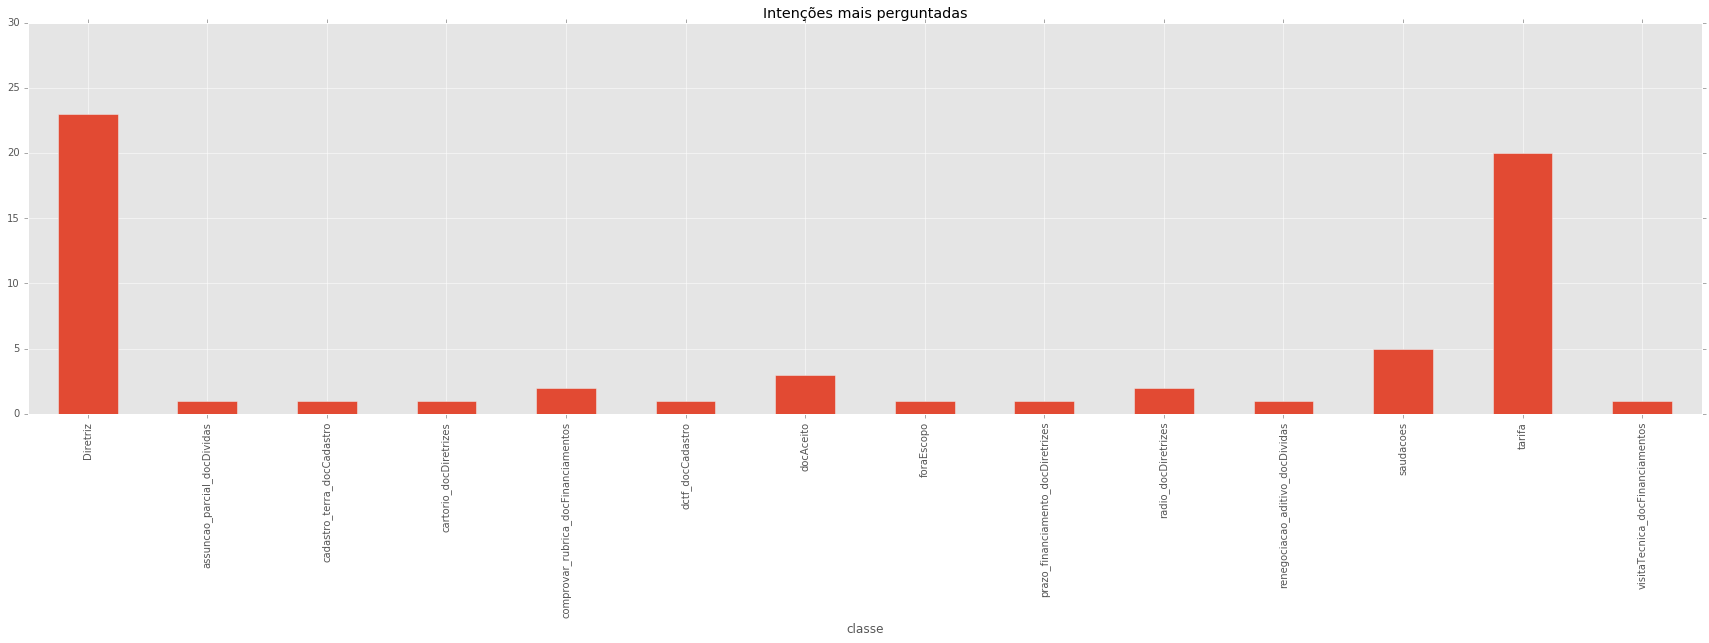

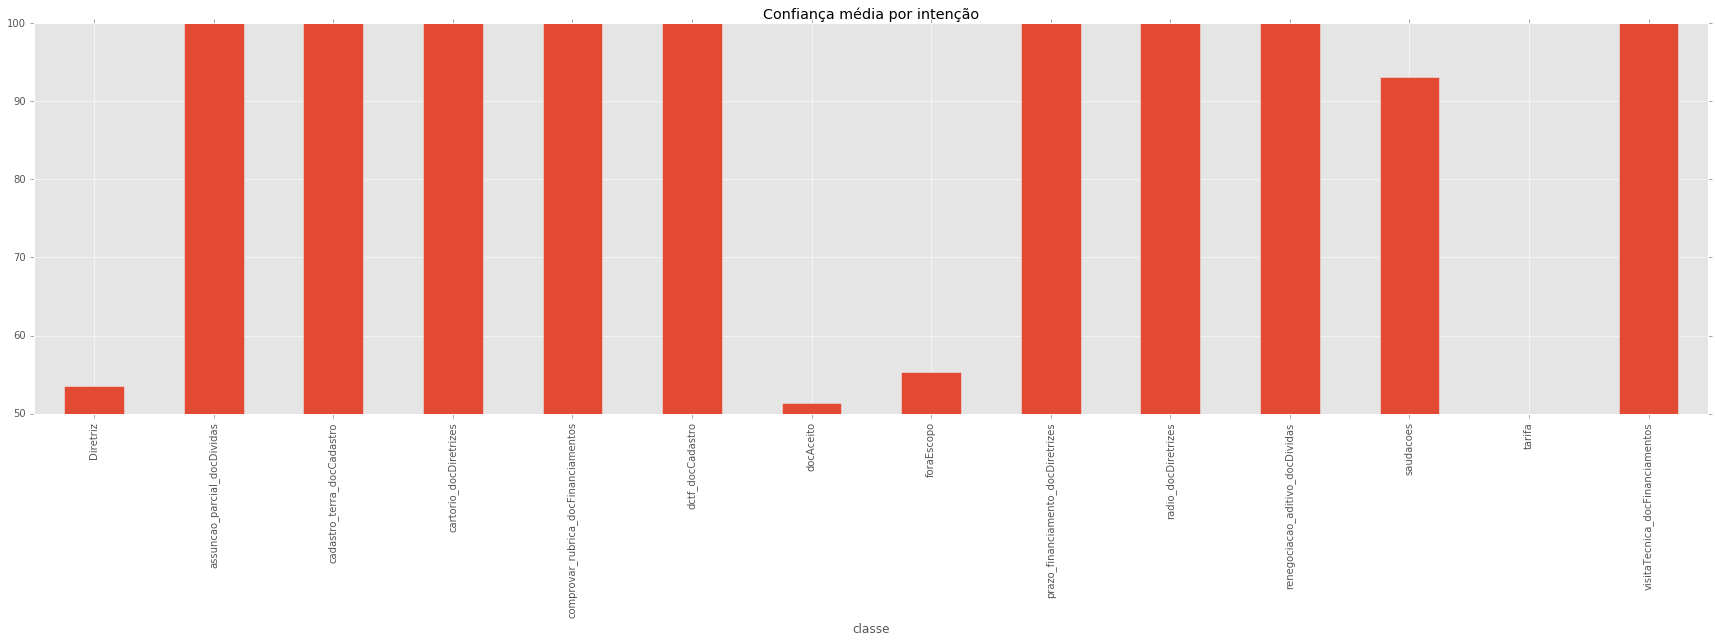

In [12]:
#print(df2)

grouped = df2.groupby('classe').sum()
grouped2 = (grouped['somaconfianca']/grouped['tamanho'])*100
grouped3 = grouped['tamanho']

print('Intenções mais perguntadas\n')
print(grouped3)
plt.figure();
#grouped3.plot()
grouped3.plot(kind='bar',x='classe', y='confiança',figsize=(30,7),ylim=(0,30),title='Intenções mais perguntadas')

print('\n\nConfiança média por intenção\n')
print(grouped2)
plt.figure();
grouped2.plot(kind='bar',x='classe', y='confiança',figsize=(30,7),ylim=(50,100),title='Confiança média por intenção')

## E como podemos fazer para tentar corrigir o problema encontrado no Exemplo 2 acima?
A Solução para este problema exige a definição de conceitos mais avançados sobre métricas de modelos de machine learning e será abordada em outro artigo.

In [37]:
df3 = pd.DataFrame(columns=['classe','input'])

#print(json_response_logs['logs'])
c = 0
for log in json_response_logs['logs']:
    if(bool(log['response']['input']) & bool(log['response']['intents'])):
        df3.loc[c] = pd.Series({'classe': log['response']['intents'][0]['intent'],'input': log['response']['input']['text']})
        c = c+1

grouped3 = df3.groupby(['classe','input'])
grouped3.size()

classe                               input                                                                                                                          
Diretriz                             df                                                                                                                                 1
                                     imagem                                                                                                                             9
                                     pdf                                                                                                                                5
                                     tudo bem com vc                                                                                                                    1
                                     word                                                                                                                  

In [6]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


#y_pred = [1,1,1,1,1,1,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,1,1,1,2,2,2,2,2,3,3]
#y_true = [1,1,1,1,1,1,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,2,2,2,1,1,1,1,3,2,2]

y_pred = [1,1,1,1,1,1,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3]
y_true = [1,1,1,1,1,1,2,2,2,2,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]


print(confusion_matrix(y_true, y_pred))


print(accuracy_score(y_true, y_pred))

print("Precisão")
print("Macro: " + str(precision_score(y_true, y_pred, average='macro')))
print("Micro: " + str(precision_score(y_true, y_pred, average='micro')))
print("Balanceada: " + str(precision_score(y_true, y_pred, average='weighted')))
print("Distribuída: " + str(precision_score(y_true, y_pred, average=None)))

print("\n\nRecall")
print("Macro: " + str(recall_score(y_true, y_pred, average='macro')))
print("Micro: " + str(recall_score(y_true, y_pred, average='micro')))
print("Balanceada: " + str(recall_score(y_true, y_pred, average='weighted')))
print("Distribuída: " + str(recall_score(y_true, y_pred, average=None)))

print("\n\nF1")
print("Macro: " + str(f1_score(y_true, y_pred, average='macro')))
print("Micro: " + str(f1_score(y_true, y_pred, average='micro')))
print("Balanceada: " + str(f1_score(y_true, y_pred, average='weighted')))
print("Distribuída: " + str(f1_score(y_true, y_pred, average=None)))


[[ 6  0  0]
 [ 0  4 90]
 [ 0  0 10]]
0.181818181818
Precisão
Macro: 0.7
Micro: 0.181818181818
Balanceada: 0.918181818182
Distribuída: [ 1.   1.   0.1]


Recall
Macro: 0.68085106383
Micro: 0.181818181818
Balanceada: 0.181818181818
Distribuída: [ 1.          0.04255319  1.        ]


F1
Macro: 0.421150278293
Micro: 0.181818181818
Balanceada: 0.140833192781
Distribuída: [ 1.          0.08163265  0.18181818]
